# Preprocessing

## Featurizing

In [1]:
import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv
import os, sys


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import load_model

%cd /home/jovyan/ASMSA/mydev


repo_dir = os.getcwd()   
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

from src.utils import split_dataset, plot_latent_space, process_trajectory
from src.asmsa_callbacks import callbacks
from src.ae import asmsa_ae

nn_model = 'ae'
latent_dim = 2

2025-08-08 16:13:33.111757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 16:13:33.124825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 16:13:33.128797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-08 16:13:33.138460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 16:13:33.758933: W tensorflow/compiler/tf2

[Errno 2] No such file or directory: '/home/jovyan/ASMSA/mydev'
/home/tedeschg/prj/ASMSA/mydev


In [2]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)


<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x776f3239afe0>

In [3]:
'''
import mdtraj as md
import numpy as np
from sklearn.utils import resample

# 1. Carica topologia e traiettoria
traj = md.load_xtc('trpcage_ds_nH.xtc', top='trpcage_npt400_nH.pdb')

# 2. Definisci la struttura di riferimento folded (frame 0)
ref = md.load_pdb('trpcage_npt400_nH.pdb')
atom_sel = traj.topology.select('protein')

# 3. Calcola l’RMSD di ogni frame rispetto al reference (in nm)
rmsd = md.rmsd(traj, ref, frame=0, atom_indices=atom_sel)

# 4. Imposta le soglie (in nm)
t1 = 0.5   # fino a 0.5 nm → folded
t2 = 1.0   # da 0.5 a 1.0 nm → semi-unfolded; >1.0 nm → unfolded

# 5. Crea le etichette (0=folded, 1=semi-unfolded, 2=unfolded)
labels = np.empty_like(rmsd, dtype=int)
labels[rmsd <= t1]                  = 0
labels[(rmsd >  t1) & (rmsd <= t2)] = 1
labels[rmsd >  t2]                  = 2

# 6. Raggruppa indici per ciascuna classe
idx0 = np.where(labels == 0)[0]  # folded
idx1 = np.where(labels == 1)[0]  # semi-unfolded
idx2 = np.where(labels == 2)[0]  # unfolded

print(f"Counts before balancing: folded={len(idx0)}, semi-unfolded={len(idx1)}, unfolded={len(idx2)}")

# 7. Bilancia con undersampling alla classe meno numerosa
n_target = min(len(idx0), len(idx1), len(idx2))
idx0_bal = resample(idx0, replace=False, n_samples=n_target, random_state=42)
idx1_bal = resample(idx1, replace=False, n_samples=n_target, random_state=42)
idx2_bal = resample(idx2, replace=False, n_samples=n_target, random_state=42)

# 8. Combina, ordina e crea la traiettoria bilanciata
idx_balanced = np.sort(np.concatenate([idx0_bal, idx1_bal, idx2_bal]))
balanced = traj.slice(idx_balanced)

# 9. Salva il nuovo XTC bilanciato
balanced.save_xtc('traj_balanced_3class_0.5_1.0nm.xtc')

print(f"Balanced dataset: {n_target} frames per classe, totale {len(idx_balanced)} frames.")

tr = "traj_balanced_3class_0.5_1.0nm.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)
'''

'\nimport mdtraj as md\nimport numpy as np\nfrom sklearn.utils import resample\n\n# 1. Carica topologia e traiettoria\ntraj = md.load_xtc(\'trpcage_ds_nH.xtc\', top=\'trpcage_npt400_nH.pdb\')\n\n# 2. Definisci la struttura di riferimento folded (frame 0)\nref = md.load_pdb(\'trpcage_npt400_nH.pdb\')\natom_sel = traj.topology.select(\'protein\')\n\n# 3. Calcola l’RMSD di ogni frame rispetto al reference (in nm)\nrmsd = md.rmsd(traj, ref, frame=0, atom_indices=atom_sel)\n\n# 4. Imposta le soglie (in nm)\nt1 = 0.5   # fino a 0.5 nm → folded\nt2 = 1.0   # da 0.5 a 1.0 nm → semi-unfolded; >1.0 nm → unfolded\n\n# 5. Crea le etichette (0=folded, 1=semi-unfolded, 2=unfolded)\nlabels = np.empty_like(rmsd, dtype=int)\nlabels[rmsd <= t1]                  = 0\nlabels[(rmsd >  t1) & (rmsd <= t2)] = 1\nlabels[rmsd >  t2]                  = 2\n\n# 6. Raggruppa indici per ciascuna classe\nidx0 = np.where(labels == 0)[0]  # folded\nidx1 = np.where(labels == 1)[0]  # semi-unfolded\nidx2 = np.where(label

In [4]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [5]:
ca_indices, n_ca, bb_indices, n_bb, features_normalized, scaler_coords, scaler_angles, coords = process_trajectory(tr, conf)


## NN preprocessing

In [6]:
# Uso:
ds_train, ds_val, ds_test, ds_all = split_dataset(features_normalized, train_size=70, val_size=15, batch_size=64, seed=42)

I0000 00:00:1754662417.524492  249713 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754662417.542314  249713 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754662417.542473  249713 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754662417.543249  249713 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Dataset Statistics:
  Train: 35000 samples, 546 batches
  Val:   7500 samples, 118 batches
  Test:  7501 samples, 118 batches
  Batch size: 64


# AE

In [7]:
'''
Batch Norm, nel caso, va prima della layer activation)
'''

'\nBatch Norm, nel caso, va prima della layer activation)\n'

In [8]:
autoencoder, encoder, decoder = asmsa_ae(
    n_features=features_normalized.shape[1],
    latent_dim=latent_dim)

autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_input (InputLayer)          │ (None, 558)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │       188,322 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 558)            │       188,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,200 (1.44 MB)

 Trainable params: 375,280 (1.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [9]:
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cb = callbacks(log_dir, latent_dim, monitor="val_loss", model=nn_model)  

learning_rate = 1e-4
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=1e-5, 
    beta_1=0.9,
    beta_2=0.999
)

# Assuming asmsa_ae function exists
ae, encoder, decoder = asmsa_ae(
    n_features=features_normalized.shape[1],
    latent_dim=latent_dim
)

mse_fn = tf.keras.losses.MeanSquaredError()
mae_fn = tf.keras.losses.MeanAbsoluteError()

# Definisco la loss ricostruzione pesata
def recon_loss(y_true, y_pred):
    mse = mse_fn(y_true, y_pred)
    mae = mae_fn(y_true, y_pred)
    return 0.8 * mse + 0.2 * mae

# Compilo l'autoencoder con la loss personalizzata
ae.compile(optimizer=optimizer,
           loss=recon_loss)


tensorboard --logdir logs/autoencoder --host localhost --port 6006

In [10]:
ae.fit(ds_train,epochs=200,validation_data=ds_val,callbacks=cb, shuffle=True)

Epoch 1/200


I0000 00:00:1754662423.594454  249784 service.cc:146] XLA service 0x63cda74150d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754662423.594476  249784 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-08 16:13:43.696989: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-08 16:13:44.130314: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 19/546 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4618    

I0000 00:00:1754662429.248462  249784 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


536/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2896
Epoch 1: val_loss improved from inf to 0.15088, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.2882 - val_loss: 0.1509 - learning_rate: 1.0000e-04
Epoch 2/200
532/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1644
Epoch 2: val_loss improved from 0.15088 to 0.14014, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1643 - val_loss: 0.1401 - learning_rate: 1.0000e-04
Epoch 3/200
544/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1517
Epoch 3: val_loss improved from 0.14014 to 0.13448, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1517 - val_loss: 0.1345 - learning_rate: 1.0000e-04
Epoch 4/200
539/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1452
Epoch 4: val_loss improved from 0.13448 to 0.13222, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1452 - val_loss: 0.1322 - learning_rate: 1.0000e-04
Epoch 5/200

In [11]:
src = f"ae_{latent_dim}d.keras"
dest = "/home/tedeschg/prj/ASMSA/mydev/models/"

!mv {src} {dest}

# Decode and visualize

In [12]:
path = f"/home/tedeschg/prj/ASMSA/mydev/models/ae_{latent_dim}d.keras"

autoencoder = load_model(
    path,
    custom_objects={"recon_loss": recon_loss}
)

encoder = autoencoder.get_layer("encoder")
decoder = autoencoder.get_layer("decoder")


In [13]:
for batch_x, _ in ds_test.take(1):
    sample_x = batch_x[30]  
    break
    
sample_x_batch = tf.expand_dims(sample_x, axis=0)
test = encoder.predict(sample_x_batch)

test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


array([[ 0.53321  , -0.5119419]], dtype=float32)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


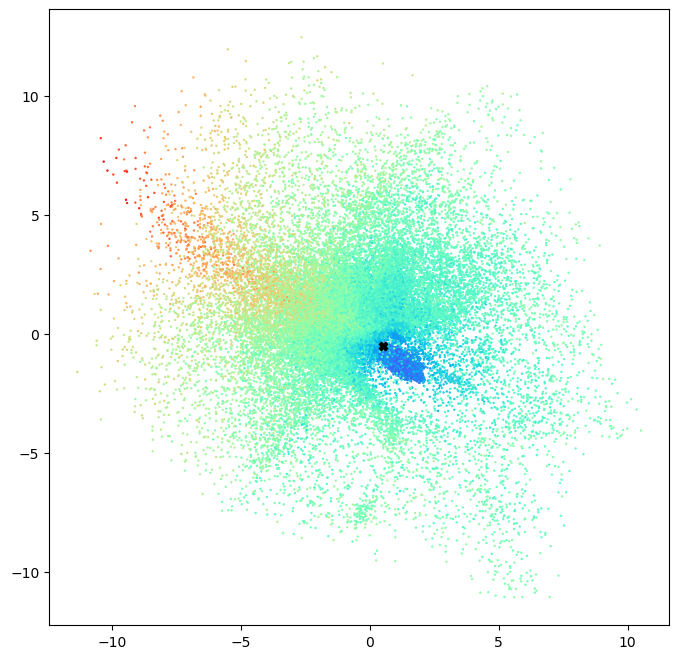

In [14]:
target = np.array([10, 0]).reshape(1, latent_dim)
emb, sample = plot_latent_space(latent_dim, encoder, ds_all, conf, tr, test, bb_indices, model=nn_model, exact=True)

In [15]:
rms_ref = md.load_pdb(conf)
rms_ref_bb  = rms_ref.atom_slice(bb_indices)
rms_ref_ca  = rms_ref.atom_slice(ca_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)
rmsd = md.rmsd(rms_tr, rms_ref)

In [16]:
p_indices = traj.topology.select("protein")
n_p = len(p_indices)

In [17]:
s = decoder.predict(sample)

coords_size = coords.shape[1]  # dimensione delle coordinate
angles_size = s.shape[1] - coords_size  # dimensione degli angoli

# Separa coordinate e angoli
s_coords = s[:, :coords_size]
s_angles = s[:, coords_size:]

# Inverti le trasformazioni separatamente
coords_orig = scaler_coords.inverse_transform(s_coords)
angles_orig = scaler_angles.inverse_transform(s_angles)

# Prendi solo le coordinate per la ricostruzione
coords_flat = coords_orig[0, :]                    
coords_p = coords_flat.reshape((n_p, 3))
mask_bb = np.isin(p_indices, bb_indices)
coords_bb = coords_p[mask_bb] 
coords_ca = coords_bb[1::4] 

new_traj = md.Trajectory(
    xyz=np.array([coords_bb]),     
    topology=rms_ref_bb.topology     
)

new_traj.save_pdb("./models/ae_reconstructed.pdb")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


In [22]:
view = nv.show_file('./models/ae_reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view

NGLWidget()

In [19]:
mse = np.mean((s[0] - sample_x.numpy())**2)
print("MSE ricostruzione:", mse)

MSE ricostruzione: 0.038798086


/home/tedeschg/prj/ASMSA/mydev/src/asmsanalysis.py:117: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
/home/tedeschg/prj/ASMSA/mydev/src/asmsanalysis.py:117: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/home/tedeschg/prj/ASMSA/mydev/src/asmsanalysis.py:117: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: User

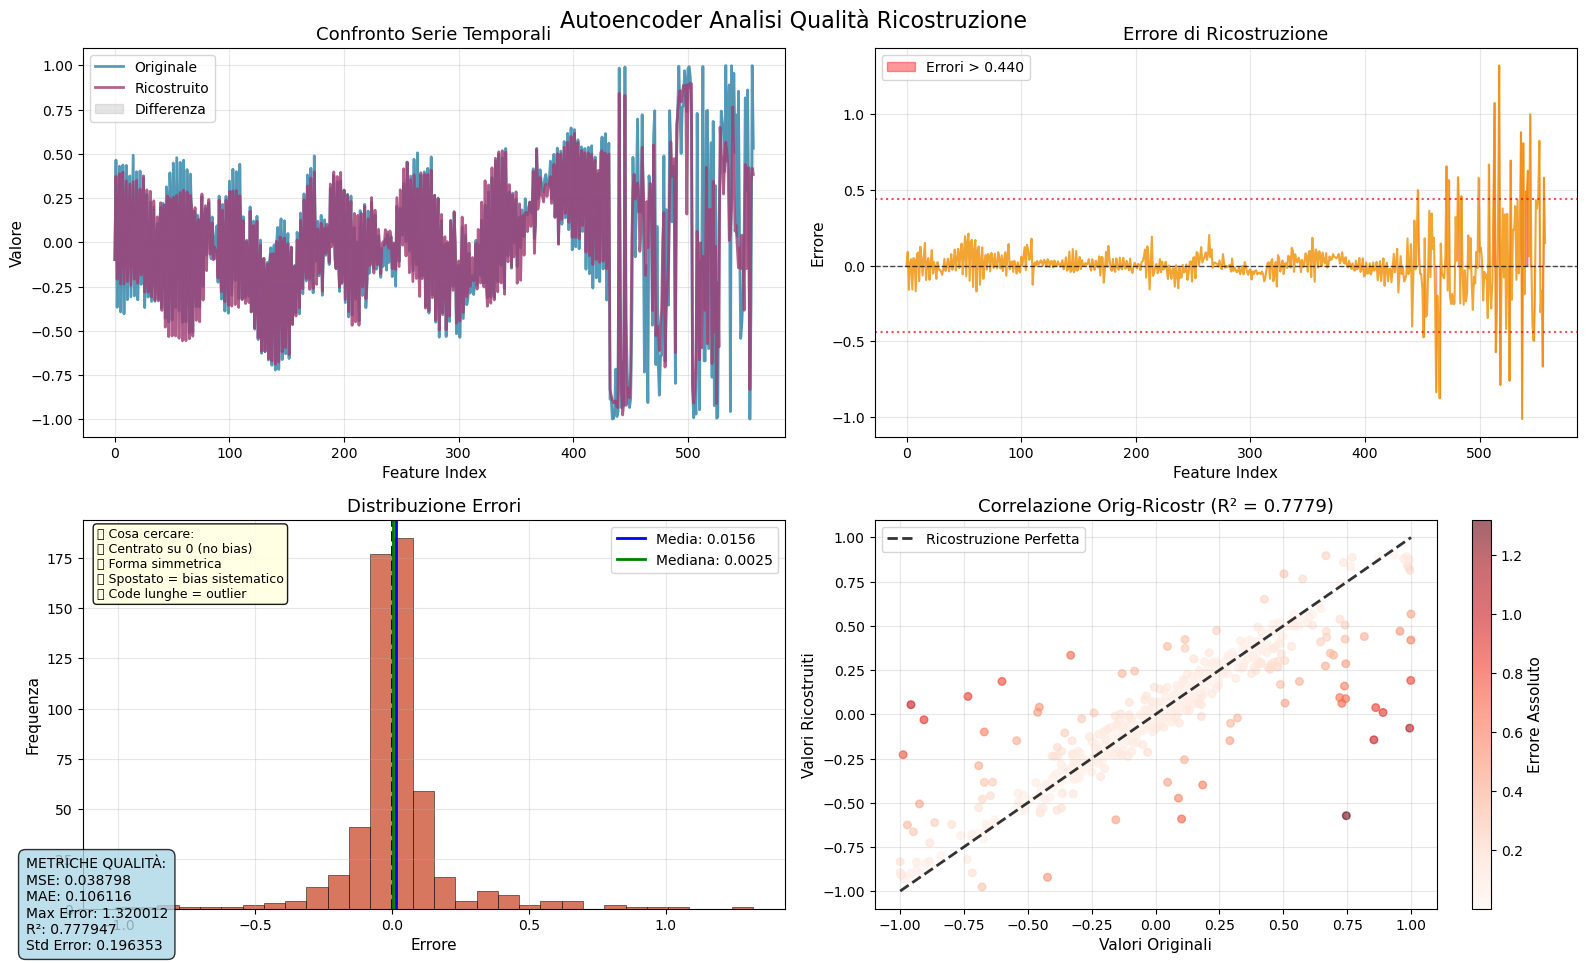

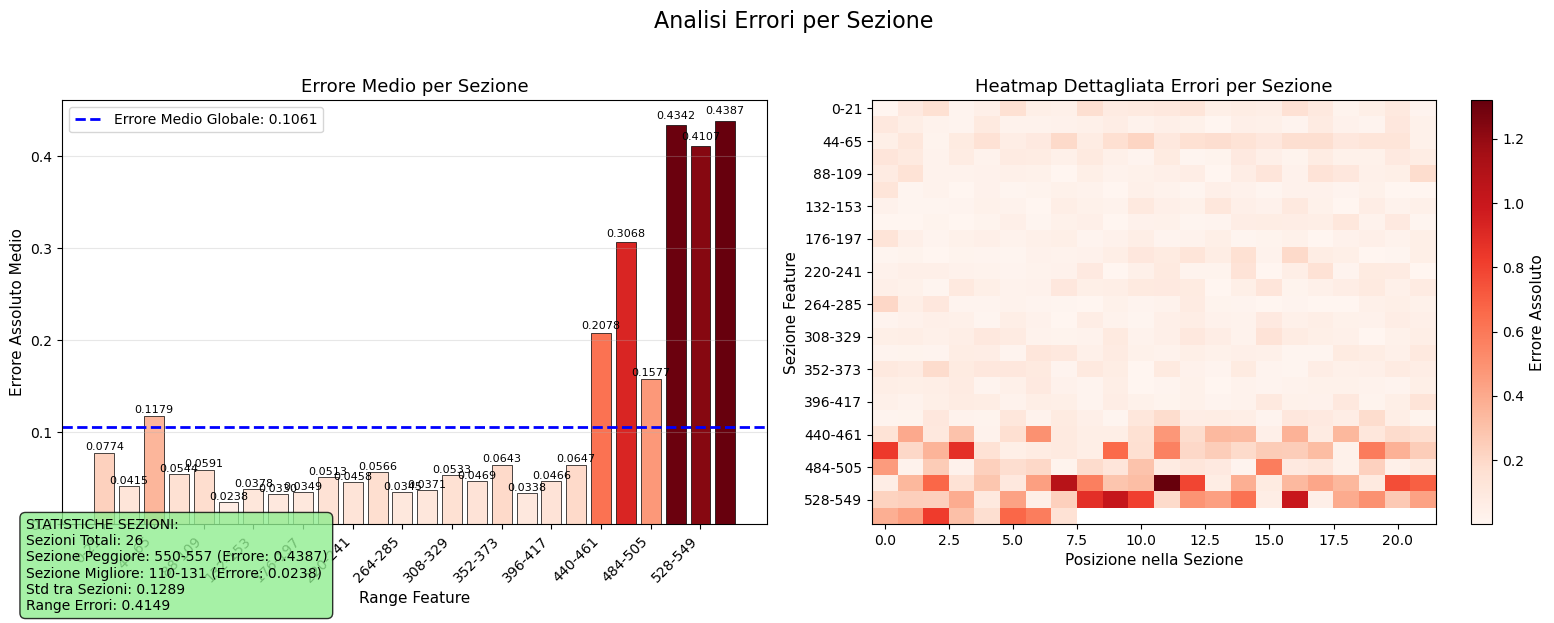


=== METRICHE RICOSTRUZIONE ===


In [20]:
from src.asmsanalysis import analyze_reconstruction, plot_section_errors
import matplotlib.pyplot as plt
# Utilizzo con i tuoi dati
# Assumendo che sample_x e s[0] siano definiti
orig = sample_x.numpy() 
recon = s[0]

# Analisi completa
fig, metrics = analyze_reconstruction(orig, recon, title_prefix="Autoencoder ")

# Solo errori per sezione
fig_sections, section_stats = plot_section_errors(orig, recon, n_sections=25, 
                                                   title="Analisi Errori per Sezione")

plt.show()

# Stampa metriche
print("\n=== METRICHE RICOSTRUZIONE ===")
for metric, value in metrics.items():
    (f"{metric.upper()}: {value:.6f}")